# Exploring Cell Coverage of Routes
* To do later: move data sources to a catalog
* An agency here is defined: as a service and an operator...

In [1]:
# Read in zip files
import fsspec
import geopandas as gpd
import intake
import numpy as np
import pandas as pd

# My utilities
import utilities
from calitp import *

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## Trip Routes 
* Bring in trip routes.

In [4]:
# Just grab some columns w/o geo, in case I want to preview the df
cols_without_geometry = [
    "agency",
    "route_name",
    "itp_id",
    "route_id",
    "route_type",
]

In [5]:
routes_df = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes.parquet"
)

In [6]:
# Find unique routes for bus only 
routes_df = utilities.unique_routes(routes_df)

In [7]:
# Fill in NA for route names and agency names
routes_df[["agency", "route_name"]] = routes_df[["agency", "route_name"]].fillna("NA")

In [8]:
f"""{routes_df.route_id.nunique()} unique route ids, {routes_df.route_name.nunique()} different route names, and {routes_df.route_length.nunique()} different shape ids. The dataframe has {len(routes_df)} rows."""

'1730 unique route ids, 1930 different route names, and 2318 different shape ids. The dataframe has 2829 rows.'

In [210]:
# Route ID is only unique to each agency.
# routes_df[[ "route_id", "agency", "route_name", ]].sort_values(['agency','route_id', ]).drop_duplicates().reset_index(drop = True)

In [9]:
# Create a df for agency-itp id, drop duplicates to get only one record per agency
agency_itp = routes_df[["agency", "itp_id"]].drop_duplicates()

In [98]:
agency_itp.shape

(169, 2)

## FCC Maps
* T-Mobile not working.

In [10]:
verizon_df = gpd.read_parquet(f"{GCS_FILE_PATH}verizon_ca_only.parquet")

In [11]:
att_df = gpd.read_parquet(f"{GCS_FILE_PATH}att_ca_only.parquet")

(<AxesSubplot:>, <AxesSubplot:>)

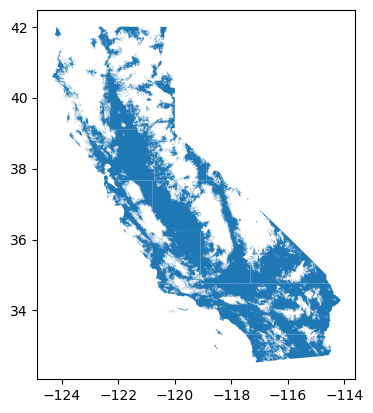

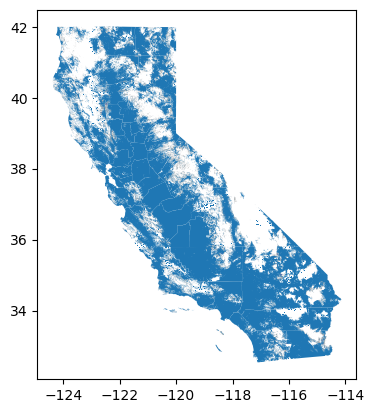

In [12]:
att_df.plot(), verizon_df.plot(),

## Overlay 

In [13]:
overlay_verizon = utilities.comparison(routes_df, verizon_df)

In [14]:
overlay_att = utilities.comparison(routes_df, att_df)

In [15]:
f"Verizon: The length of the overlay dataframe is {len(overlay_verizon)}"

'Verizon: The length of the overlay dataframe is 3215'

In [149]:
f"AT&T: The length of the overlay dataframe is {len(overlay_att)}"

'AT&T: The length of the overlay dataframe is 3159'

In [150]:
# overlay_att.plot("route_length", legend=True), overlay_verizon.plot("route_length")

### Test finding % with a single route...

In [151]:
# Test a single route that goes through 2 counties
# This one goes through San Francisco & Marin.
single_route_overlay = overlay_att.loc[overlay_att["route_name"] == "via Civic Center"]

In [152]:
# Original Df
single_route_og = routes_df.loc[routes_df["route_name"] == "via Civic Center"]

In [183]:
# Merge
second_merge = pd.merge(
    single_route_og,
    single_route_overlay,
    how="outer",
    on=["agency", "route_name", "route_id", "route_type"],
    suffixes=["_original", "_overlay"],
)

In [185]:
second_merge.drop(columns = ['geometry_original','geometry_overlay'])

,itp_id_original,route_id,route_type,route_name,agency,route_length_original,itp_id_overlay,route_length_overlay
0,194,1203,3,via Civic Center,Marin Transit,35769.34,194,35534.09
1,194,1394,3,via Civic Center,Marin Transit,40838.51,194,38013.75
2,194,1394,3,via Civic Center,Marin Transit,40838.51,194,2797.78


### Test with AT&T

In [229]:
# Merge
att_merge = pd.merge(
    overlay_att,
    routes_df,
    how="inner",
    on=["agency", "route_id", "route_name", "itp_id"],
    suffixes=["_original", "_overlay"],
)

In [230]:
# Check the lengths 
f'{len(routes_agg)}, {len(att_agg)}, {len(att_merge)}'

'2829, 2822, 3159'

In [231]:
# Overlap, mutiply by 100
att_merge["overlap_percentage"] = (
    ((att_merge["route_length_overlay"] / att_merge["route_length_original"]) * 100)
).astype("int64")

In [232]:
# Bin percentages
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [233]:
att_merge["binned"] = pd.cut(att_merge["overlap_percentage"], bins)

In [234]:
att_merge.binned.value_counts()

(90, 100]    1607
(0, 10]         0
(10, 20]        0
(20, 30]        0
(30, 40]        0
(40, 50]        0
(50, 60]        0
(60, 70]        0
(70, 80]        0
(80, 90]        0
Name: binned, dtype: int64

#### What's the right way to determine a threshold?

In [235]:
# Filter out for routes that have have < 75 percent coverage
att_merge_low_coverage = att_merge.loc[att_merge["overlap_percentage"] < 70]

In [236]:
f"{len(att_merge_low_coverage)} after filtering out for rows that  < 70% coverage."

'0 after filtering out for rows that  < 70% coverage.'

## Trips
* How many trips are running for a route?

In [237]:
trips_df = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/trips_2022-05-04_all.parquet"
)

In [238]:
trips_df.shape

(104934, 14)

In [239]:
# Merge agency names with calitp_itp_id, trips_df on the left
trips_df = pd.merge(
    trips_df,
    agency_itp,
    how="left",
    left_on=["calitp_itp_id"],
    right_on=["itp_id"],
)

In [240]:
# trips_df[['agency','itp_id','calitp_itp_id']].drop_duplicates()

In [241]:
# Try to standardize route id for the 2 dfs
att_merge_low_coverage["route_id"] = (
    att_merge_low_coverage["route_id"].str.lower().str.strip()
)
trips_df["route_id"] = trips_df["route_id"].str.lower().str.strip()

In [242]:
att_routes_list = att_merge_low_coverage["route_id"].unique().tolist()

In [243]:
# Filter out for route IDS
trips_df2 = trips_df[trips_df["route_id"].isin(att_routes_list)]

In [244]:
# So many route ids disappeared
f'{trips_df2["route_id"].nunique()} routes left after filtering trips_df compared to {len(att_routes_list)} routes in overlay.'

'0 routes left after filtering trips_df compared to 0 routes in overlay.'

In [245]:
# Checking which ones are missing.
id_routes = set(att_routes_list)
id_trips = set(trips_df2.route_id.unique().tolist())
missing_routes = list(id_routes - id_trips)

In [246]:
f"{1-(len(id_trips)/len(id_routes))}% of routes are missing."

ZeroDivisionError: division by zero

In [ ]:
# Merge to get percentages and additional information. 
# What to merge on? 
# Are route IDS only unique to an agency or across the state
trips_df3 = pd.merge(
    trips_df2,
    att_merge_low_coverage,
    how="outer",
    left_on=["route_id", "calitp_itp_id", "agency"],
    right_on=["route_id", "itp_id", "agency"],
    indicator=True,
)

In [ ]:
trips_df3["_merge"].value_counts()

In [ ]:
# Sum up number of trips taken by route using trip id?
# Some routes are owned by the different agency - double counting them 
(
    trips_df3.loc[trips_df3["_merge"] == "both"]
    .groupby(
        [
            "route_name",
            "overlap_percentage", "agency"
        ]
    )
    .agg({"trip_id": "nunique"})
    .rename(columns={"trip_id": "total_trips"})
)